In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,RepeatVector,TimeDistributed,LSTM,Input,Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model
import seaborn as sns

In [2]:
dataframe = pd.read_csv("GE.CSV")
print(type(dataframe))
dataframe

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-01-02,0.776242,0.777494,0.766226,0.767478,0.159365,2316288
1,1970-01-05,0.767478,0.771234,0.757462,0.763722,0.158585,4233216
2,1970-01-06,0.762470,0.762470,0.737430,0.741186,0.153906,3544320
3,1970-01-07,0.743690,0.754958,0.743690,0.744942,0.154685,4602624
4,1970-01-08,0.747446,0.758714,0.747446,0.751202,0.155985,13897728
...,...,...,...,...,...,...,...
12818,2020-10-23,7.930000,8.030000,7.560000,7.630000,7.617370,132563200
12819,2020-10-26,7.460000,7.560000,7.280000,7.380000,7.367784,104254400
12820,2020-10-27,7.400000,7.400000,7.090000,7.100000,7.088247,98170000
12821,2020-10-28,7.510000,7.860000,7.410000,7.420000,7.407717,253494100


In [3]:
df = dataframe[['Date','Close']]
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Date,Close
0,1970-01-02,0.767478
1,1970-01-05,0.763722
2,1970-01-06,0.741186
3,1970-01-07,0.744942
4,1970-01-08,0.751202
...,...,...
12818,2020-10-23,7.630000
12819,2020-10-26,7.380000
12820,2020-10-27,7.100000
12821,2020-10-28,7.420000


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-4-b9c6864122be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


<AxesSubplot:xlabel='Date', ylabel='Close'>

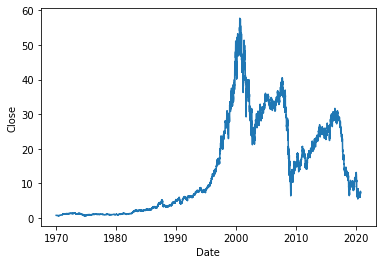

In [5]:
sns.lineplot(x=df['Date'],y=df['Close'])


In [6]:
print("Start date is :",df['Date'].min())
print("End date is:",df['Date'].max())

Start date is : 1970-01-02 00:00:00
End date is: 2020-10-29 00:00:00


### ALLocating traning and test set

In [7]:
train,test = df.loc[df['Date']<= '2003-12-31'],df.loc[df['Date']>'2003-12-31']

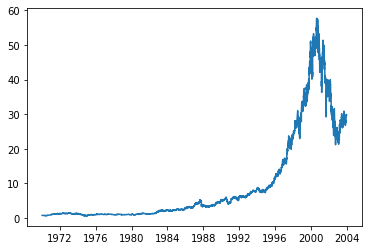

In [8]:
plt.plot(train['Date'],train['Close'])

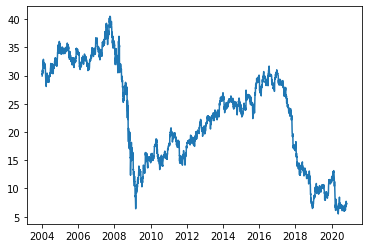

In [9]:
plt.plot(test['Date'],test['Close'])

In [10]:
#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

In [11]:
#Now normalising
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-11-7c83936d6475>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
<ipython-input-11-7c83936d6475>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [12]:
print(train)

           Date     Close
0    1970-01-02 -0.661313
1    1970-01-05 -0.661597
2    1970-01-06 -0.663304
3    1970-01-07 -0.663019
4    1970-01-08 -0.662545
...         ...       ...
8581 2003-12-24  1.530324
8582 2003-12-26  1.517218
8583 2003-12-29  1.525227
8584 2003-12-30  1.517218
8585 2003-12-31  1.536148

[8586 rows x 2 columns]


In [13]:
print(test)

            Date     Close
8586  2004-01-02  1.546341
8587  2004-01-05  1.579833
8588  2004-01-06  1.564543
8589  2004-01-07  1.587113
8590  2004-01-08  1.628614
...          ...       ...
12818 2020-10-23 -0.141684
12819 2020-10-26 -0.160614
12820 2020-10-27 -0.181816
12821 2020-10-28 -0.157586
12822 2020-10-29 -0.161372

[4237 rows x 2 columns]


In [14]:
seq_size = 30 # Numbr of time steps to look back

In [15]:
# defining a model 

def to_sequences(x,y,seq_size=1):
    x_values=[]
    y_values=[]
    
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values),np.array(y_values)
        
    

In [16]:
X_train,y_train = to_sequences(train[['Close']], train['Close'], seq_size)
X_test,y_test = to_sequences(test[['Close']],test['Close'],seq_size)

In [17]:
print("X_train is \n",X_train )
print("y_train is \n",y_train )
print("X_test is \n",X_test )
print("y_test is\n",y_test)

print("Size of X_train is \n",X_train.shape )
print("Size of y_train is \n",y_train.shape)
print("Size of X_test is \n",X_test.shape )
print("Size of y_test is\n",y_test.shape)


X_train is 
 [[[-0.66131277]
  [-0.66159718]
  [-0.6633036 ]
  ...
  [-0.66709564]
  [-0.66605283]
  [-0.66633723]]

 [[-0.66159718]
  [-0.6633036 ]
  [-0.66301919]
  ...
  [-0.66605283]
  [-0.66633723]
  [-0.66719044]]

 [[-0.6633036 ]
  [-0.66301919]
  [-0.66254519]
  ...
  [-0.66633723]
  [-0.66719044]
  [-0.66681124]]

 ...

 [[ 1.34393652]
  [ 1.31044508]
  [ 1.30534861]
  ...
  [ 1.54488508]
  [ 1.5303235 ]
  [ 1.51721823]]

 [[ 1.31044508]
  [ 1.30534861]
  [ 1.3512172 ]
  ...
  [ 1.5303235 ]
  [ 1.51721823]
  [ 1.52522711]]

 [[ 1.30534861]
  [ 1.3512172 ]
  [ 1.42620888]
  ...
  [ 1.51721823]
  [ 1.52522711]
  [ 1.51721823]]]
y_train is 
 [-0.66719044 -0.66681124 -0.66738004 ...  1.52522711  1.51721823
  1.53614816]
X_test is 
 [[[ 1.54634118]
  [ 1.57983262]
  [ 1.56454306]
  ...
  [ 1.68904371]
  [ 1.67302603]
  [ 1.66283302]]

 [[ 1.57983262]
  [ 1.56454306]
  [ 1.58711329]
  ...
  [ 1.67302603]
  [ 1.66283302]
  [ 1.68685957]]

 [[ 1.56454306]
  [ 1.58711329]
  [ 1.6286135

## Creating AutoEncoder Model

In [18]:

model = Sequential()
model.add(LSTM(128,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(LSTM(64,activation='relu',return_sequences=False))
model.add(Dropout(rate=0.02))

model.add(RepeatVector(X_train.shape[1])) #RepeatVector is bridge between encoders and decoders

model.add(LSTM(64,activation='relu',return_sequences=True)) #Note- 3rd and 4th LSTM layers are mirror to 1st and 2nd LSTM layer
# model.add(LSTM(128,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer='adam',loss='mse')
model.summary()







Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
__________________________________________________

## FITTING the model

In [19]:
# history = model.fit(X_train,y_train,epochs=50,batch_size=32,validation_split=0.1,verbose=1)

## Loading the model

In [20]:
from keras.models import load_model
model = load_model("AutoEncoced+lstm2.h5")

In [33]:
# plt.plot(model.history['loss'], label='Training loss')
# plt.plot(model.history['val_loss'], label='Validation loss')
# plt.legend()

In [22]:
model.evaluate(X_test,y_test)

132/132 [==============================] - 7s 41ms/step - loss: 0.0011


0.0011363493977114558

In [ ]:
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

## Predicting the training set

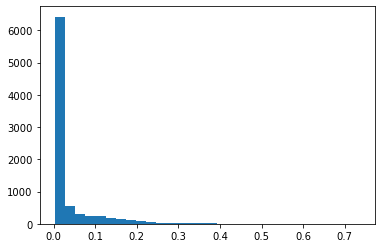

In [26]:
X_pred = model.predict(X_train)
trainMAE = np.mean(np.abs(X_pred - X_train),axis=1)
plt.hist(trainMAE,bins=30)
max_trainMAE = 0.3 #or define the value of max threshold

In [27]:
print("trainMAE:\n",trainMAE)
print("max_trainMAE:\n",max_trainMAE)

trainMAE:
 [[0.0130101 ]
 [0.01297562]
 [0.01303449]
 ...
 [0.0827178 ]
 [0.08128438]
 [0.07168925]]
max_trainMAE:
 0.3


## Predicting the test set

(array([433., 988., 772., 535., 389., 279., 249., 142., 115.,  63.,  53.,
         43.,  36.,  21.,  17.,  23.,  12.,   7.,  11.,   5.,   2.,   4.,
          0.,   4.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([0.00974921, 0.02564665, 0.04154409, 0.05744153, 0.07333897,
        0.08923641, 0.10513385, 0.12103129, 0.13692873, 0.15282617,
        0.16872361, 0.18462105, 0.20051849, 0.21641593, 0.23231337,
        0.24821081, 0.26410825, 0.28000569, 0.29590313, 0.31180057,
        0.32769801, 0.34359545, 0.35949289, 0.37539033, 0.39128777,
        0.40718521, 0.42308265, 0.43898009, 0.45487753, 0.47077497,
        0.48667241]),
 <BarContainer object of 30 artists>)

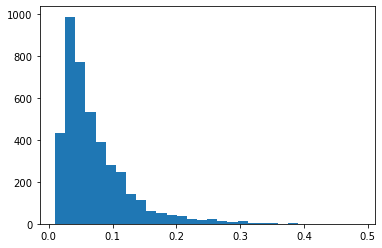

In [30]:
X_pred = model.predict(X_test)
testMAE = np.mean(np.abs(X_pred - X_test),axis=1)
plt.hist(testMAE,bins=30)

In [79]:
print("test mae",testMAE)

test mae [[0.0584716 ]
 [0.04951351]
 [0.05347809]
 ...
 [0.05190949]
 [0.03949068]
 [0.04572102]]


In [80]:
print("trainnmae info\n",np.info(trainMAE))
print("testmae info\n",np.info(testMAE))

class:  ndarray
shape:  (4207, 1)
strides:  (8, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cfd8ff1a10
byteorder:  little
byteswap:  False
type: float64
trainnmae info
 None
class:  ndarray
shape:  (4207, 1)
strides:  (8, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cec056adb0
byteorder:  little
byteswap:  False
type: float64
testmae info
 None


### Capture all details in a DataFrame for easy plotting



In [87]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df


,Date,Close
8616,2004-02-17,1.686860
8617,2004-02-18,1.665017
8618,2004-02-19,1.654096
8619,2004-02-20,1.661377
8620,2004-02-23,1.713798
...,...,...
12818,2020-10-23,-0.141684
12819,2020-10-26,-0.160614
12820,2020-10-27,-0.181816
12821,2020-10-28,-0.157586


In [89]:
anomaly_df['testMAE'] = testMAE

In [90]:
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df

,Date,Close,testMAE,max_trainMAE
8616,2004-02-17,1.686860,0.058472,0.3
8617,2004-02-18,1.665017,0.049514,0.3
8618,2004-02-19,1.654096,0.053478,0.3
8619,2004-02-20,1.661377,0.055223,0.3
8620,2004-02-23,1.713798,0.050084,0.3
...,...,...,...,...
12818,2020-10-23,-0.141684,0.069106,0.3
12819,2020-10-26,-0.160614,0.066375,0.3
12820,2020-10-27,-0.181816,0.051909,0.3
12821,2020-10-28,-0.157586,0.039491,0.3


In [94]:
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE'] #IT gives boolean value if testMAE is greater than MAX_trainMAE
anomaly_df

,Date,Close,testMAE,max_trainMAE,anomaly
8616,2004-02-17,1.686860,0.058472,0.3,False
8617,2004-02-18,1.665017,0.049514,0.3,False
8618,2004-02-19,1.654096,0.053478,0.3,False
8619,2004-02-20,1.661377,0.055223,0.3,False
8620,2004-02-23,1.713798,0.050084,0.3,False
...,...,...,...,...,...
12818,2020-10-23,-0.141684,0.069106,0.3,False
12819,2020-10-26,-0.160614,0.066375,0.3,False
12820,2020-10-27,-0.181816,0.051909,0.3,False
12821,2020-10-28,-0.157586,0.039491,0.3,False


In [93]:
anomaly_df['Close'] = test[seq_size:]['Close'] 
anomaly_df

,Date,Close,testMAE,max_trainMAE,anomaly
8616,2004-02-17,1.686860,0.058472,0.3,False
8617,2004-02-18,1.665017,0.049514,0.3,False
8618,2004-02-19,1.654096,0.053478,0.3,False
8619,2004-02-20,1.661377,0.055223,0.3,False
8620,2004-02-23,1.713798,0.050084,0.3,False
...,...,...,...,...,...
12818,2020-10-23,-0.141684,0.069106,0.3,False
12819,2020-10-26,-0.160614,0.066375,0.3,False
12820,2020-10-27,-0.181816,0.051909,0.3,False
12821,2020-10-28,-0.157586,0.039491,0.3,False


# Plot testMAE vs MAx_trainMAE

<AxesSubplot:xlabel='Date', ylabel='testMAE'>

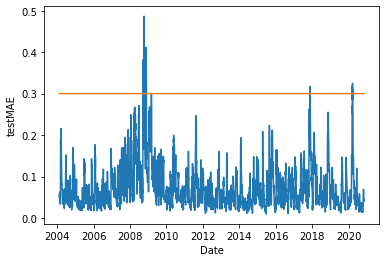

In [100]:
sns.lineplot(x=anomaly_df['Date'],y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'],y=anomaly_df['max_trainMAE'])

#Value above yellow line means there are only few values that are above threshold value we set that is 0.3

In [102]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

# Plot ANOMALIES

<AxesSubplot:xlabel='Date'>

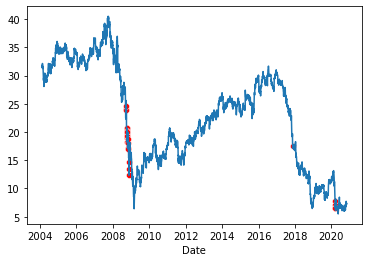

In [110]:
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')
#Anomalies day are in red plot

In [ ]:
!git add AutoEncoced+lstm2.h5 AutoEncoder+lstm.ipynb GE.csv
! git commit -m "17:05/12-05-2021"
! git push origin main